<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/OSA/OSA_SVM_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
# ==========================
# 0) Imports & Config
# ==========================
from __future__ import annotations

import os, json, time, math, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Dict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

RANDOM_STATE = 23
np.random.seed(RANDOM_STATE)

# ==========================
# 1) User settings
# ==========================
# Set this once. Examples:
# data_path = "ClevelandDataSet.csv"
data_path = "OSA_Data_with_Groups.csv"
# data_path = "ClevelandDataSet.csv"  # <- update if needed

if not os.path.exists(data_path):
    raise FileNotFoundError(f"File not found: {data_path}")
print(f"Using dataset: {data_path}")


Using dataset: OSA_Data_with_Groups.csv


In [171]:
# ==========================
# 2) Load data (CSV/XLS/XLSX)
# ==========================
def load_data(path: str) -> pd.DataFrame:
    ext = os.path.splitext(path)[-1].lower()
    if ext == ".csv":
        return pd.read_csv(path)
    elif ext in (".xls", ".xlsx"):
        return pd.read_excel(path)
    else:
        raise ValueError(f"Unsupported file format: {ext}")

df0 = load_data(data_path).dropna(how="all").reset_index(drop=True)
print("Columns:", df0.columns.tolist())
print("Shape (raw):", df0.shape)

Columns: ['Age', 'Sex', 'Height', 'Weight', 'BMI>30', 'Neck>17', 'Airway MF', 'MF >2', 'BAN', 'OSA']
Shape (raw): (1000, 10)


In [172]:
# ==========================
# 3) Preprocess
#    - Target = last column
#    - Numeric: coerce -> impute median
#    - Categorical: get_dummies(drop_first=True)
# ==========================
target_col = df0.columns[-1]
print(f"Using target column (last): {target_col}")

y_series = df0[target_col]
X_df = df0.drop(columns=[target_col])

# Separate by dtype
num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df.columns.difference(num_cols).tolist()

# Numeric: coerce, then fill NA with median
for c in num_cols:
    X_df[c] = pd.to_numeric(X_df[c], errors="coerce")
    if X_df[c].isna().any():
        X_df[c] = X_df[c].fillna(X_df[c].median())

# Categorical: stringify, fill NA, then one-hot encode
if cat_cols:
    X_df[cat_cols] = X_df[cat_cols].astype(str).fillna("NA")
    X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)

# Target handling:
# - If numeric but not strictly {0,1}, map >0 -> 1 (Cleveland-style)
# - If non-numeric, map common labels to 0/1 then coerce
label_map = {"yes":1,"y":1,"true":1,"t":1,"positive":1,"pos":1,"m":1,"male":1,
             "no":0,"n":0,"false":0,"f":0,"negative":0,"neg":0,"fem":0,"female":0}
if y_series.dtype == "object":
    y_tmp = y_series.astype(str).str.strip().str.lower().map(label_map)
    y = pd.to_numeric(y_tmp, errors="coerce")
else:
    y = pd.to_numeric(y_series, errors="coerce")

if not set(pd.unique(y.dropna())).issubset({0,1}):
    y = (y.fillna(0) > 0).astype(int)
else:
    y = y.fillna(0).astype(int)

# Combine final df with target for convenience
df = X_df.copy()
df["target"] = y

print("Shape (processed):", df.shape)
display(df.head(10))


Using target column (last): OSA
Shape (processed): (1000, 10)


,Age,Sex,Height,Weight,BMI>30,Neck>17,Airway MF,MF >2,BAN,target
0,2.0,0,2.0,1.0,0,0,1,0,0,0
1,1.0,0,2.0,1.0,0,0,1,0,0,0
2,2.0,1,2.0,1.0,0,0,1,0,0,0
3,1.0,0,1.0,1.0,0,0,1,0,0,0
4,2.0,0,1.0,1.0,0,0,1,0,0,0
5,1.0,0,2.0,1.0,0,0,2,0,0,0
6,3.0,1,3.0,1.0,0,1,1,0,1,0
7,2.0,0,1.0,1.0,1,0,2,0,1,0
8,3.0,0,2.0,2.0,1,0,2,0,1,0
9,1.0,0,1.0,1.0,0,1,2,0,1,0


In [173]:
# ==========================
# 4) Utils & Models
# ==========================
def is_binary(y_arr) -> bool:
    return np.unique(y_arr).size == 2

def make_pipeline(C: float = 1.0, gamma="scale") -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=C, gamma=gamma, probability=True, random_state=RANDOM_STATE))
    ])

def safe_metrics(y_true, y_pred, y_proba=None) -> Dict[str, float]:
    avg = "binary" if is_binary(y_true) else "macro"
    out = {
        "accuracy":  float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, average=avg, zero_division=0)),
        "recall":    float(recall_score(y_true, y_pred, average=avg, zero_division=0)),
        "f1":        float(f1_score(y_true, y_pred, average=avg, zero_division=0)),
    }
    if y_proba is not None and is_binary(y_true):
        out["roc_auc"] = float(roc_auc_score(y_true, y_proba))
    return out

def evaluate_cv_score(X, y, C: float, gamma_val: float, folds: int = 3) -> float:
    scoring = "roc_auc" if is_binary(y) else "accuracy"
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    model = make_pipeline(C=C, gamma=gamma_val)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    return float(np.mean(scores))

@dataclass
class ESState:
    mean: np.ndarray
    sigma: float
    best_score: float
    best_params: np.ndarray
    no_improve: int = 0

BOUNDS = np.array([[-3.0, 3.0], [-4.0, 2.0]])  # [log10(C), log10(gamma)]

def _clip(x: np.ndarray) -> np.ndarray:
    return np.minimum(np.maximum(x, BOUNDS[:, 0]), BOUNDS[:, 1])

def es_optimize(X, y, iters=10, lam=6, mu=3, patience=3, folds=3, verbose=True):
    rng = np.random.RandomState(RANDOM_STATE)
    w = np.log(mu + 0.5) - np.log(np.arange(1, mu + 1))
    w = w / np.sum(w)

    state = ESState(mean=np.array([0.0, -1.0]), sigma=0.8,
                    best_score=-np.inf, best_params=np.array([0.0, -1.0]))
    hist = {"gen": [], "best_cv": []}

    for gen in range(1, iters+1):
        Z = rng.randn(lam, 2)
        Y = state.mean + state.sigma * Z
        Y = np.array([_clip(yv) for yv in Y])

        scores = np.empty(lam, dtype=float)
        for i, cand in enumerate(Y):
            C = 10.0 ** cand[0]
            gamma_val = 10.0 ** cand[1]
            scores[i] = evaluate_cv_score(X, y, C, gamma_val, folds=folds)

        idx = np.argsort(scores)[::-1][:mu]
        parents, parent_scores = Y[idx], scores[idx]
        new_mean = (w[:, None] * parents).sum(axis=0)

        improved = parent_scores[0] > state.best_score + 1e-8
        state.sigma = float(np.clip(state.sigma * (1.06 if improved else 0.90), 1e-3, 2.5))

        if parent_scores[0] > state.best_score + 1e-10:
            state.best_score  = float(parent_scores[0])
            state.best_params = parents[0]
            state.no_improve  = 0
        else:
            state.no_improve += 1

        state.mean = new_mean
        hist["gen"].append(gen)
        hist["best_cv"].append(state.best_score)

        if verbose:
            print(f"[ES] Gen {gen:02d}/{iters} best_cv={state.best_score:.4f} "
                  f"sigma={state.sigma:.3f} log10C={state.best_params[0]:.3f} log10γ={state.best_params[1]:.3f}")
        if state.no_improve >= patience:
            if verbose: print(f"Early stopping (no improvement in {patience} generations).")
            break

    return {
        "C": float(10.0 ** state.best_params[0]),
        "gamma": float(10.0 ** state.best_params[1]),
        "cv_score": float(state.best_score),
    }, hist


In [174]:
# ==========================
# 5) Split + Default SVM (with metrics DataFrame)
# ==========================
from sklearn.model_selection import train_test_split
import time

# Ensure make_pipeline uses probability=True
def make_pipeline(C: float = 1.0, gamma="scale") -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf",
                    C=C,
                    gamma=gamma,
                    probability=True,      # enables calibrated probabilities
                    random_state=RANDOM_STATE))
    ])

# Prepare data
X = df.drop(columns=["target"]).values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Train default model
default_model = make_pipeline(C=1.0, gamma="scale")
t0 = time.time()
default_model.fit(X_train, y_train)
t_def = time.time() - t0

# Predictions + probabilities
yhat_tr  = default_model.predict(X_train)
yhat_te  = default_model.predict(X_test)
proba_tr = default_model.predict_proba(X_train)[:, 1] if is_binary(y) else None
proba_te = default_model.predict_proba(X_test)[:, 1] if is_binary(y) else None

# Metrics
m_def_tr = safe_metrics(y_train, yhat_tr, proba_tr)
m_def_te = safe_metrics(y_test,  yhat_te,  proba_te)

# Build DataFrame
metrics_df = pd.DataFrame([m_def_tr, m_def_te], index=["Train", "Test"])
metrics_df = metrics_df[["accuracy", "precision", "recall", "f1"]]  # keep only main metrics

print(f"Training time: {t_def:.3f}s")
display(metrics_df.round(4))


Training time: 0.124s


,accuracy,precision,recall,f1
Train,0.6862,0.6922,0.8009,0.7426
Test,0.6550,0.6549,0.8230,0.7294


In [175]:
# ==========================
# 6) ES-SVM (tune C & gamma)
# ==========================
best, es_hist = es_optimize(
    X_train, y_train,
    iters=12, lam=6, mu=3,
    patience=3, folds=3, verbose=True
)

# make_pipeline already has probability=True
es_model = make_pipeline(C=best["C"], gamma=best["gamma"])
t1 = time.time()
es_model.fit(X_train, y_train)
t_es = time.time() - t1

# Predictions + probabilities
yhat_tr_es  = es_model.predict(X_train)
yhat_te_es  = es_model.predict(X_test)
proba_tr_es = es_model.predict_proba(X_train)[:, 1] if is_binary(y) else None
proba_te_es = es_model.predict_proba(X_test)[:, 1] if is_binary(y) else None

# Metrics
m_es_tr = safe_metrics(y_train, yhat_tr_es, proba_tr_es)
m_es_te = safe_metrics(y_test,  yhat_te_es,  proba_te_es)

print("ES-SVM (best params):", best)
print(f"Training time: {t_es:.3f}s")

# Build DataFrame for clear output
es_metrics_df = pd.DataFrame([m_es_tr, m_es_te], index=["Train", "Test"])
es_metrics_df = es_metrics_df[["accuracy", "precision", "recall", "f1"]]

display(es_metrics_df.round(4))


[ES] Gen 01/12 best_cv=0.6966 sigma=0.848 log10C=-0.294 log10γ=-1.910
[ES] Gen 02/12 best_cv=0.6966 sigma=0.763 log10C=-0.294 log10γ=-1.910
[ES] Gen 03/12 best_cv=0.6966 sigma=0.687 log10C=-0.294 log10γ=-1.910
[ES] Gen 04/12 best_cv=0.6966 sigma=0.618 log10C=-0.294 log10γ=-1.910
Early stopping (no improvement in 3 generations).
ES-SVM (best params): {'C': 0.5081144047776579, 'gamma': 0.012303601246479381, 'cv_score': 0.696557242901728}
Training time: 0.111s


,accuracy,precision,recall,f1
Train,0.665,0.6769,0.7788,0.7243
Test,0.670,0.6667,0.8319,0.7402


In [176]:
# ==========================
# 7) Compact report (saved in root)
# ==========================
report = pd.DataFrame([
    {"Model":"Default SVM","Split":"Train", **m_def_tr, "fit_time_sec":round(t_def,3), "C":1.0, "gamma":"scale"},
    {"Model":"Default SVM","Split":"Test",  **m_def_te, "fit_time_sec":round(t_def,3), "C":1.0, "gamma":"scale"},
    {"Model":"ES-SVM","Split":"Train",      **m_es_tr,  "fit_time_sec":round(t_es,3),  "C":best["C"], "gamma":best["gamma"]},
    {"Model":"ES-SVM","Split":"Test",       **m_es_te,  "fit_time_sec":round(t_es,3),  "C":best["C"], "gamma":best["gamma"]},
])
display(report.style.format(precision=4))

report_path = "svm_es_report.csv"
best_path   = "es_best_params.json"
report.to_csv(report_path, index=False)
with open(best_path, "w") as f:
    json.dump(best, f, indent=2)
print("Saved:", os.path.abspath(report_path), "|", os.path.abspath(best_path))

,Model,Split,accuracy,precision,recall,f1,roc_auc,fit_time_sec,C,gamma
0,Default SVM,Train,0.6863,0.6922,0.8009,0.7426,0.7569,0.1240,1.0000,scale
1,Default SVM,Test,0.6550,0.6549,0.8230,0.7294,0.6998,0.1240,1.0000,scale
2,ES-SVM,Train,0.6650,0.6769,0.7788,0.7243,0.7089,0.1110,0.5081,0.0123
3,ES-SVM,Test,0.6700,0.6667,0.8319,0.7402,0.7514,0.1110,0.5081,0.0123


Saved: /content/svm_es_report.csv | /content/es_best_params.json


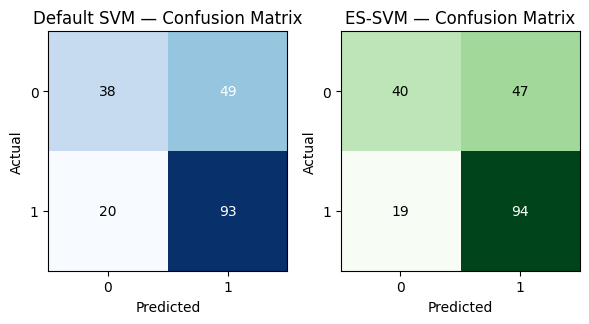

Saved figure: /content/confusion_matrices.png


In [177]:
# ==========================
# 8a) Figure 1: Confusion Matrices (auto white/black text)
# ==========================
fig1, axes1 = plt.subplots(1, 2, figsize=(6, 4.5))

# CM Default
cm_def = confusion_matrix(y_test, yhat_te)
im0 = axes1[0].imshow(cm_def, cmap="Blues")
axes1[0].set_title("Default SVM — Confusion Matrix")
axes1[0].set_xlabel("Predicted"); axes1[0].set_ylabel("Actual")
axes1[0].set_xticks([0,1]); axes1[0].set_yticks([0,1])
thresh_def = cm_def.max() / 2.0
for i in range(cm_def.shape[0]):
    for j in range(cm_def.shape[1]):
        color = "white" if cm_def[i, j] > thresh_def else "black"
        axes1[0].text(j, i, str(cm_def[i, j]), ha="center", va="center", color=color)

# CM ES
cm_es = confusion_matrix(y_test, yhat_te_es)
im1 = axes1[1].imshow(cm_es, cmap="Greens")
axes1[1].set_title("ES-SVM — Confusion Matrix")
axes1[1].set_xlabel("Predicted"); axes1[1].set_ylabel("Actual")
axes1[1].set_xticks([0,1]); axes1[1].set_yticks([0,1])
thresh_es = cm_es.max() / 2.0
for i in range(cm_es.shape[0]):
    for j in range(cm_es.shape[1]):
        color = "white" if cm_es[i, j] > thresh_es else "black"
        axes1[1].text(j, i, str(cm_es[i, j]), ha="center", va="center", color=color)

plt.tight_layout()
fig1_path = "confusion_matrices.png"
plt.savefig(fig1_path, dpi=160)
plt.show()
print("Saved figure:", os.path.abspath(fig1_path))


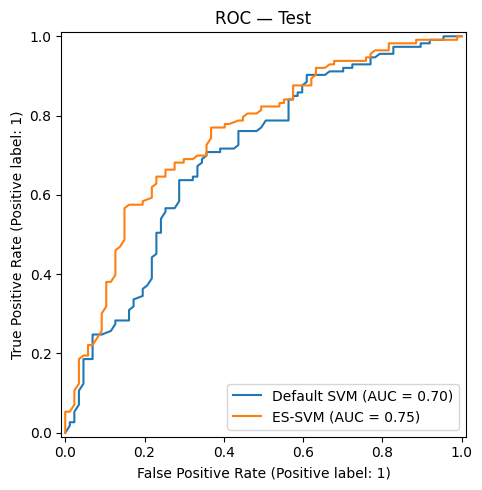

Saved ROC figure: /content/roc_curve.png


In [178]:
# ==========================
# 8b) Figure 2a: ROC Curve
# ==========================
if proba_te is not None:
    fig_roc, ax_roc = plt.subplots(figsize=(6, 5))
    RocCurveDisplay.from_predictions(y_test, proba_te, name="Default SVM", ax=ax_roc)
    if proba_te_es is not None:
        RocCurveDisplay.from_predictions(y_test, proba_te_es, name="ES-SVM", ax=ax_roc)
    ax_roc.set_title("ROC — Test")
    fig_roc.tight_layout()
    fig_roc_path = "roc_curve.png"
    plt.savefig(fig_roc_path, dpi=160)
    plt.show()
    print("Saved ROC figure:", os.path.abspath(fig_roc_path))
else:
    print("No probabilities available — ROC not generated.")

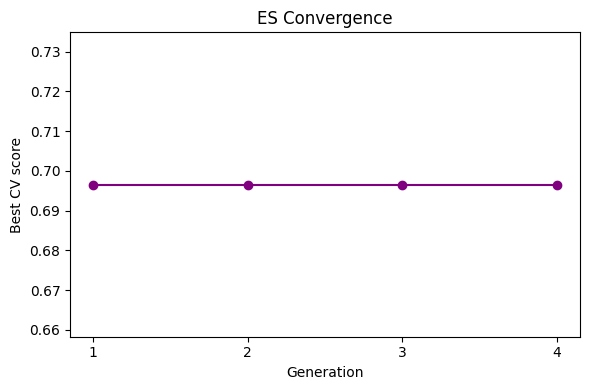

Saved ES Convergence figure: /content/es_convergence.png


In [179]:

# ==========================
# 8c) Figure 2b: ES Convergence
# ==========================
fig_es, ax_es = plt.subplots(figsize=(6, 4))
ax_es.plot(es_hist["gen"], es_hist["best_cv"], marker="o", color="purple")
ax_es.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_es.set_xlabel("Generation")
ax_es.set_ylabel("Best CV score")
ax_es.set_title("ES Convergence")
fig_es.tight_layout()
fig_es_path = "es_convergence.png"
plt.savefig(fig_es_path, dpi=160)
plt.show()
print("Saved ES Convergence figure:", os.path.abspath(fig_es_path))


In [180]:
# ==========================
# 9) Export ES-SVM model as JSON (root)
# ==========================
scaler = es_model.named_steps["scaler"]
svc    = es_model.named_steps["svc"]
model_json_path = "ES_SVM_Model.json"

export = {
    "feature_names": df.drop(columns=["target"]).columns.tolist(),
    "scaler": {"mean": scaler.mean_.tolist(), "scale": scaler.scale_.tolist()},
    "svm": {
        "kernel": "rbf",
        "gamma": float(getattr(svc, "_gamma", svc.gamma if isinstance(svc.gamma, float) else best["gamma"])),
        "support_vectors": svc.support_vectors_.tolist(),
        "dual_coef": svc.dual_coef_.tolist(),
        "intercept": svc.intercept_.tolist(),
        "classes": svc.classes_.tolist()
    }
}
with open(model_json_path, "w") as f:
    json.dump(export, f, indent=2)
print("Saved model JSON:", os.path.abspath(model_json_path))


Saved model JSON: /content/ES_SVM_Model.json


In [181]:
# ==========================
# Build HTML app — compact layout, centered title, no helper paragraph
# ==========================
from pathlib import Path

# Keep your feature order in sync with the model JSON
feature_order = list(export["feature_names"]) if "export" in globals() and "feature_names" in export \
    else ["Age", "Height", "Weight", "Sex", "BMI>30", "Neck>17", "Airway MF", "MF >2", "BAN", "AHI"]

# UI schema (selects for grouped/binary features; numeric for AHI)
schema = {
    "Age":      {"type":"select","label":"Age Group","help":"1 (19–47), 2 (48–59), 3 (60–96)",
                 "options":[("1 (19–47)",1),("2 (48–59)",2),("3 (60–96)",3)]},
    "Height":   {"type":"select","label":"Height Group (inches)","help":"1 (15–64.9), 2 (65–69.4), 3 (69.5–79)",
                 "options":[("1 (15–64.9)",1),("2 (65–69.4)",2),("3 (69.5–79)",3)]},
    "Weight":   {"type":"select","label":"Weight Group (lb)","help":"1 (49–199.9), 2 (200–245.9), 3 (246–500)",
                 "options":[("1 (49–199.9)",1),("2 (200–245.9)",2),("3 (246–500)",3)]},
    "Sex":      {"type":"select","label":"Sex","help":"Female=0, Male=1","options":[("Female (0)",0),("Male (1)",1)]},
    "BMI>30":   {"type":"select","label":"BMI > 30","help":"No=0, Yes=1","options":[("No (0)",0),("Yes (1)",1)]},
    "Neck>17":  {"type":"select","label":"Neck > 17 in","help":"No=0, Yes=1","options":[("No (0)",0),("Yes (1)",1)]},
    "Airway MF":{"type":"select","label":"Airway MF Count","help":"Select 1–4","options":[("1",1),("2",2),("3",3),("4",4)]},
    "MF >2":    {"type":"select","label":"MF > 2","help":"No=0, Yes=1","options":[("No (0)",0),("Yes (1)",1)]},
    "BAN":      {"type":"select","label":"BAN","help":"Allowed 0–4","options":[("0",0),("1",1),("2",2),("3",3),("4",4)]},
    "AHI":      {"type":"number","label":"AHI (0–150)","help":"Numeric 0–150","attrs":{"min":"0","max":"150","step":"1"}},
}

def _build_inputs_html(order, ui):
    blocks=[]
    for name in order:
        cfg = ui[name]; label=cfg["label"]; help_text=cfg.get("help","")
        if cfg["type"]=="select":
            opts = "\n".join([f'<option value="{v}">{lab}</option>' for lab,v in cfg["options"]])
            blocks.append(f'''
              <div class="field">
                <label for="{name}" class="dark-label">{label}</label>
                <select id="{name}" class="control">{opts}</select>
              </div>''')
        else:
            attrs = " ".join(f'{k}="{v}"' for k,v in cfg.get("attrs",{}).items())
            blocks.append(f'''
              <div class="field">
                <label for="{name}" class="dark-label">{label}</label>
                <input id="{name}" type="number" class="control" {attrs}/>
              </div>''')
    return "\n".join(blocks)

inputs_html = _build_inputs_html(feature_order, schema)

html_template = f"""<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8"/>
<meta name="viewport" content="width=device-width, initial-scale=1.0"/>
<title>OSA Diagnosis Using the ES-SVM Model</title>
<style>
  :root {{ --blue:#0b66c3; --ink:#0c1b3a; }}
  /* Compact page to fit on a single screen */
  body {{ font-family: Arial, Helvetica, sans-serif; margin:0; background:#fbfcff; }}
  .header {{
    background: var(--blue);
    color: #fff;
    padding: 10px 12px;              /* tighter */
    box-shadow: 0 2px 8px rgba(0,0,0,0.06);
    text-align: center;               /* centered title */
  }}
  .header h1 {{ margin:0; font-size:1.35rem; line-height:1.25; }}
  .header .sub {{ margin-top:2px; opacity:0.95; font-size:0.9rem; }}

  .wrap {{ max-width: 900px; margin: 10px auto; padding: 0 12px; }}  /* narrower, less margin */
  .card {{ background:#fff; border:1px solid #e6e9ef; border-radius:10px; padding:12px;
           box-shadow: 0 1px 8px rgba(0,0,0,0.04); }}

  .grid {{
    display:grid;
    grid-template-columns: repeat(3, minmax(180px,1fr));  /* 3 columns to reduce height */
    gap: 8px 12px;                                        /* tighter spacing */
  }}
  .field {{ display:flex; flex-direction:column; gap:4px; }}
  label.dark-label {{ color:darkblue; font-weight:700; font-size:0.95rem; }}
  .control {{ width:100%; padding:8px; border-radius:8px; border:1px solid #cfd4dc; background:#fff; font-size:0.95rem; }}

  .row {{ margin-top:10px; display:flex; flex-wrap:wrap; align-items:center; gap:8px; }}
  button {{ padding:8px 12px; border-radius:8px; border:1px solid #8792a2; background:#f3f6fa; cursor:pointer; font-weight:600; }}
  input[type="file"] {{ border:1px dashed #c2c8d2; padding:6px; border-radius:8px; background:#f6f8ff; }}

  .result-main {{ margin-top:8px; font-size:1.05rem; font-weight:800; color:var(--ink); }}
</style>
</head>
<body>
  <div class="header">
    <h1>OSA Diagnosis Using the ES-SVM Model</h1>
    <div class="sub">Developer: Alaa Sheta</div>
  </div>

  <div class="wrap">
    <div class="card">
      <div class="row">
        <input id="jsonFile" type="file" accept=".json,application/json"/>
        <span id="status" style="color:#4b5563;font-size:0.9rem;"></span>
      </div>

      <div class="grid" style="margin-top:8px">
        {inputs_html}
      </div>

      <div class="row">
        <button id="predictBtn">Predict</button>
        <span id="fileInfo" style="color:#4b5563;font-size:0.9rem;"></span>
      </div>

      <div class="result-main" id="outProb"></div>
    </div>
  </div>

<script>
let MODEL = null;

function readJSONFile(file) {{
  return new Promise((resolve, reject) => {{
    const r = new FileReader();
    r.onload = e => {{
      try {{ resolve(JSON.parse(e.target.result)); }}
      catch(err) {{ reject(new Error('Invalid JSON: ' + err.message)); }}
    }};
    r.onerror = () => reject(new Error('Failed to read file.'));
    r.readAsText(file, 'utf-8');
  }});
}}

document.getElementById('jsonFile').addEventListener('change', async (e) => {{
  const f = e.target.files[0];
  const info = document.getElementById('fileInfo');
  const status = document.getElementById('status');
  if (!f) {{ info.textContent=''; MODEL=null; return; }}
  info.textContent = 'Model: ' + f.name;
  status.textContent = 'Loading...';
  try {{
    const obj = await readJSONFile(f);
    if (!obj.feature_names || !obj.scaler || !obj.svm) throw new Error('JSON missing required keys.');
    MODEL = obj;
    status.textContent = 'Model loaded.';
  }} catch(err) {{
    MODEL = null;
    status.textContent = 'Error: ' + err.message;
  }}
}});

// --- SVM helpers ---
function rbfKernel(x, sv, gamma) {{
  let s=0.0; for (let i=0;i<x.length;i++) {{ const d=x[i]-sv[i]; s+=d*d; }}
  return Math.exp(-gamma*s);
}}
function decisionFunction(x, model) {{
  const gamma = model.svm.gamma;
  const SV = model.svm.support_vectors;
  const dual = model.svm.dual_coef[0];
  const b = model.svm.intercept[0];
  let f = 0.0;
  for (let i=0;i<SV.length;i++) {{ f += dual[i]*rbfKernel(x, SV[i], gamma); }}
  return f + b;
}}
function standardize(x_raw, mean, scale) {{
  const out = new Array(x_raw.length);
  for (let i=0;i<x_raw.length;i++) out[i] = (x_raw[i]-mean[i]) / scale[i];
  return out;
}}

document.getElementById('predictBtn').addEventListener('click', () => {{
  const status = document.getElementById('status');
  const outProb = document.getElementById('outProb');
  outProb.textContent='';
  try {{
    if (!MODEL) throw new Error('Upload the model JSON first.');
    const featureNames = MODEL.feature_names;
    const mean = MODEL.scaler.mean;
    const scale = MODEL.scaler.scale;

    const x_raw = [];
    for (const name of featureNames) {{
      const el = document.getElementById(name);
      if (!el) throw new Error('Missing input for: ' + name);
      const v = parseFloat(el.value);
      if (Number.isNaN(v)) throw new Error('Please select/fill all inputs.');
      x_raw.push(v);
    }}

    const xz = standardize(x_raw, mean, scale);
    const f  = decisionFunction(xz, MODEL);

    // Class by sign of decision
    const cls = f >= 0 ? MODEL.svm.classes[1] : MODEL.svm.classes[0];

    // Probability(OSA=1): Platt scaling if available; else logistic fallback
    let A = MODEL.svm.probA, B = MODEL.svm.probB;
    let p1;
    if (A !== undefined && B !== undefined && isFinite(A) && isFinite(B)) {{
      p1 = 1 / (1 + Math.exp(A * f + B));  // calibrated probability
    }} else {{
      p1 = 1 / (1 + Math.exp(-f));         // approximate probability
    }}

    outProb.textContent = 'Probability(OSA=1): ' + p1.toFixed(3) + '  |  Predicted class: ' + cls;
    status.textContent = 'Done.';
  }} catch (err) {{
    status.textContent = 'Error: ' + err.message;
  }}
}});
</script>
</body>
</html>
"""

Path("ES_SVM_App.html").write_text(html_template, encoding="utf-8")
print("Saved HTML app:", Path("ES_SVM_App.html").resolve())


Saved HTML app: /content/ES_SVM_App.html


In [182]:
# ==========================
# 11) Export code cells (root)
#     Works in Jupyter environments where _ih exists.
# ==========================
try:
    export_code = []
    for cell in _ih:
        if isinstance(cell, str) and cell.strip().startswith(('#','from ','import ','def ','class ','@')):
            export_code.append(cell)
    code_json_path = "SVM_ES_Code.json"
    with open(code_json_path, "w") as f:
        json.dump({"cells_code_history": export_code}, f, indent=2)
    print("Saved code JSON:", os.path.abspath(code_json_path))
except Exception as e:
    print("Code export skipped (no _ih history in this environment):", e)


Saved code JSON: /content/SVM_ES_Code.json
